In [19]:
import uproot
import awkward as ak
import numpy as np

In [20]:
# open file
# https://opendata.cern.ch/record/80017 (ttbar)
file = uproot.open("DAOD_PHYSLITE.37621239._000001.pool.root.1")

### Get to know your data
What objects are in this file? What's the name of the ttree? 

In [56]:
#file.keys()

In [40]:
# accessing ttree
# tree = file["insert_tree_name_here"]
tree = file["CollectionTree"]

How many events are in this ttree? 

In [41]:
#len(tree)
#tree.keys()
#tree.show()
print("Number of events:", len(tree))

Number of events: 1426


We can read TBranches as arrays using tree.arrays([insert_list_of_branch_names_here]). Fill in the blanks associated with Muons.

In [42]:
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
# Muons = tree.arrays([...])
Muons = tree.arrays(["AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"])

[give some explanation about event ordering] How many electrons are in the 15th event? What are their charges. How many muons are in the 15th event? What are their charges?

In [73]:
# 3 electrons with charges:
Electrons["AnalysisElectronsAuxDyn.charge"][14]

<Array [1, 1, 1] type='3 * float32'>

In [75]:
# 1 muon with charge:
Muons["AnalysisMuonsAuxDyn.charge"][14]

<Array [1] type='1 * float32'>

## Ready for analysis
To make our lives easier, ak.zip combines arrays into a single structure as a collection of records. 

In [51]:
e = ak.zip({
    "pt" : Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta" : Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi" : Electrons["AnalysisElectronsAuxDyn.phi"],
    "mass" : Electrons["AnalysisElectronsAuxDyn.m"],
    "charge" : Electrons["AnalysisElectronsAuxDyn.charge"]
})
mu = ak.zip({
    "pt" : Muons["AnalysisMuonsAuxDyn.pt"],
    "eta" : Muons["AnalysisMuonsAuxDyn.eta"],
    "phi" : Muons["AnalysisMuonsAuxDyn.phi"],
    "charge" : Muons["AnalysisMuonsAuxDyn.charge"]
})

Calculate the tranverse momentum components for electrons and Energy, using the above.  

In [54]:
# Fn. To Calculate Invm
def Px(pt, phi):
    return pt*np.cos(phi)

def Py(pt,phi):
    return pt*np.sin(phi)

def Pz(pt,eta):
    return pt*np.sinh(eta)

def E(pt, eta, m):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + m**2)

e_px = Px(e.pt,e.phi)
e_py = Py(e.pt,e.phi)
e_pz = Pz(e.pt,e.eta)
e_E = E(e.pt,e.eta,e.mass)

The invariant mass of two oppositely charged leptons is defined as [blah blah]. Create a function, using the functions above for energy and momentum components, that calculates the invariant mass in GeV.

In [ ]:
def calc_invm(p1, p2):
    sumpx = Px(p1.pt,p1.phi) + Px(p2.pt,p2.phi)
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt,p2.phi)
    sumpz = Pz(p1.pt,p1.eta) + Pz(p2.pt,p2.eta)
    try:
        sumE = E(p1.pt,p1.eta,p1.mass) + E(p2.pt,p2.eta,p2.mass)
    except AttributeError:
        sumE = E(p1.pt,p1.eta,0) + E(p2.pt,p2.eta,0)    
    
    invm = np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)
    return invm/1000.0

### Data Selection

In [55]:
# do some data selection example 

Make a selection for muons and electrons with pt greater than 25 GeV and events with more than 2 leptons. 

In [7]:
def selection_calc(lepton):
    cut = ((lepton.pt > 25000) & (ak.num(lepton.charge) >= 2))
    data_cut = lepton[cut]
    pairs = ak.flatten(ak.combinations(data_cut, 2, axis = 1))
    opp_charge = pairs[(ak.prod([pairs[:]["0"].charge, pairs[:]["1"].charge], axis =0) == -1)]
    invm = calc_invm(opp_charge[:]["0"],opp_charge[:]["1"])
    return invm

In [16]:
e_invm = selection_calc(e)
m_invm = selection_calc(mu)
leptons = np.concatenate((e_invm,m_invm))

Text(0.5, 0, '[GeV]')

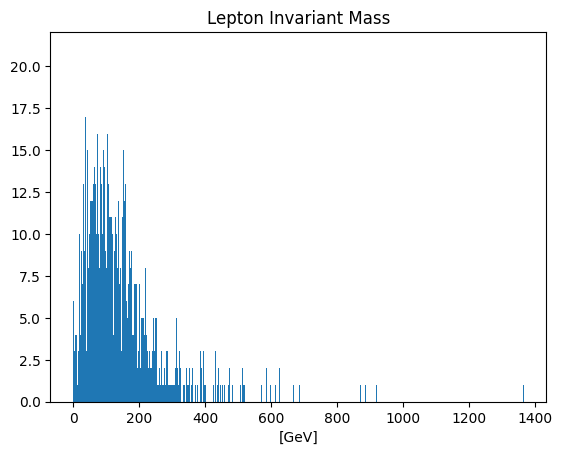

In [18]:
import matplotlib.pyplot as plt
plt.hist(leptons, bins=np.arange(min(leptons),max(leptons) +2) - 0.5)
plt.title("Lepton Invariant Mass")
plt.xlabel("[GeV]")